<a href="https://colab.research.google.com/github/mrbundles-GIT/nepal/blob/main/Richter's_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Driven Data Competition

This is an entry to the Richter's Predictor competition hosted by DrivenData.  ( [link here](https://www.drivendata.org/competitions/57/nepal-earthquake/)) 

Ill run through some models to find the one that might fit.


In [1]:
#@title Import Libraries { vertical-output: true, display-mode: "form" }

import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

!pip install category_encoders
from category_encoders import OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 119 kB/s 


In [3]:
#@title Data Import

#Submission Format	
filepath = "/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/submission_format.csv"
submission_format = pd.read_csv(filepath, index_col='building_id')

# Test Values	
filepath = "/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/test_values.csv"
test_values = pd.read_csv(filepath, index_col='building_id')

#Train Labels	
filepath = "/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/train_labels.csv"
train_labels= pd.read_csv(filepath, index_col='building_id')

#Train Values
filepath = "/content/drive/MyDrive/Public Data Projects/Nepal/Richters_Predictor/train_values.csv"
train_values= pd.read_csv(filepath, index_col='building_id')

In [4]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [5]:
train_labels

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3
...,...
688636,2
669485,3
602512,3


In [6]:
test_values

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,...,1,0,0,0,0,0,0,0,0,0
663567,10,1407,11907,3,25,6,7,n,r,n,...,0,0,0,0,0,0,0,0,0,0
1049160,22,1136,7712,1,50,3,3,t,r,n,...,0,0,0,0,0,0,0,0,0,0


## EDA (Exploratory Data Analysis)

I'll run through a few visualuizations to spot useful features in the data.


In [7]:
#@title damage_grade
print (train_labels["damage_grade"].value_counts())

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64


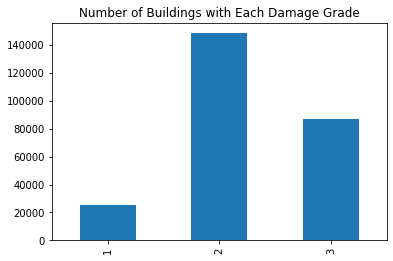

In [8]:
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

In [9]:
selected_features = ['foundation_type', 
                     'area_percentage', 
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone']

train_values_subset = train_values[selected_features]

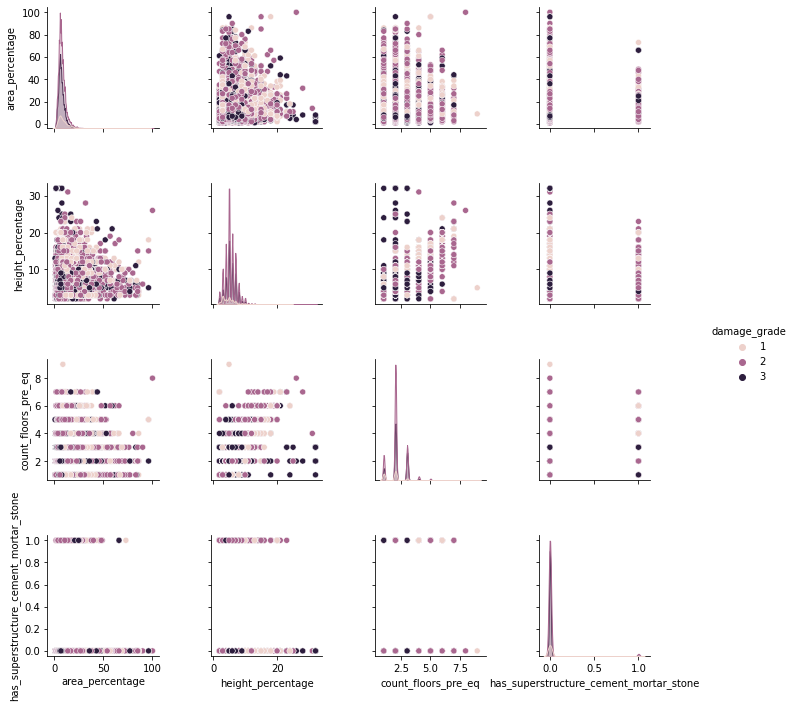

In [10]:
sns.pairplot(train_values_subset.join(train_labels), 
             hue='damage_grade')

Pre-process the Data


In [11]:
train_values_subset = pd.get_dummies(train_values_subset)

THE ERROR METRIC – MICRO F1

The metric for the competitions is F1 score, which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the micro averaged F1 score.

In Python, you can easily calculate this loss using sklearn.metrics.f1_score with the keyword argument average='micro'. Here are some references that discuss the micro-averaged F1 score further:

Scikit-Learn Documentation
Blog Post

BUILD THE MODEL
This probably isn't your first data science competition (and if it is––welcome!), so you know as well as we do that random forests are often a good first model to try. We'll give random forests a shot here, and leave the stacked classifiers and deep learning models up to you.

Random Forest
In Scikit Learn, it almost couldn't be easier to grow a random forest with a fiew lines of code. We'll also show you how to throw in some mean standardization of the features and assemble it all into a pipeline.

In [12]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

The make_pipeline function automatically names the steps in your pipeline as a lowercase version of whatever the object name is.

In [13]:
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

From here we can easily test a few different models using GridSearchCV.

In [14]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [15]:
gs.fit(train_values_subset, train_labels.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

Take a look at the best params.

In [16]:
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 100}

And the in-sample F1 micro score.

Note that we use the class predictions (.predict()), not the class probabilities (.predict_proba()).

In [17]:
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.5894183061461775

Remember, a perfect micro F1 score would be 1, so this is not a bad start given that we have 3 classes. Let's make some predictions on the test set!

TIME TO PREDICT AND SUBMIT
For the F1 Micro metric, we'll be using the class predictions, not the class probabilities. Let's load up the data, process it, and see what we get on the leaderboard.

In [18]:
# test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')


Select the subset of features we used to train the model and create dummy variables.

In [19]:
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

Make Predictions
Note that we use the class predictions, not the class probabilities.

In [20]:
predictions = gs.predict(test_values_subset)

Save Submission
We can use the column name and index from the submission format to ensure our predictions are in the form.

In [21]:
# submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')

In [22]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [23]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,2
421793,2


In [24]:
my_submission.to_csv('submission.csv')

Check the head of the saved file

In [25]:
!head submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,2
421793,2
871976,2
691228,2
896100,3
343471,2
